In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#Import Model Packages 
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import inv, eig, svd

from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import yfinance as yf
data = yf.download(['GLD','SPTL','SPY','UUP'],start='2012-01-01')

[*********************100%***********************]  4 of 4 completed


In [4]:
data['Close'].head()

,GLD,SPTL,SPY,UUP
Date,,,,
2012-01-03,155.919998,34.509998,127.500000,22.280001
2012-01-04,156.710007,34.259998,127.699997,22.400000
2012-01-05,157.779999,34.174999,128.039993,22.639999
2012-01-06,157.199997,34.330002,127.709999,22.719999
2012-01-09,156.500000,34.375000,128.020004,22.639999


In [5]:
data = data['Close']

In [6]:
print(data)

                   GLD       SPTL         SPY        UUP
Date                                                    
2012-01-03  155.919998  34.509998  127.500000  22.280001
2012-01-04  156.710007  34.259998  127.699997  22.400000
2012-01-05  157.779999  34.174999  128.039993  22.639999
2012-01-06  157.199997  34.330002  127.709999  22.719999
2012-01-09  156.500000  34.375000  128.020004  22.639999
...                ...        ...         ...        ...
2022-11-29  162.729996  29.650000  395.230011  28.840000
2022-11-30  164.809998  29.850000  407.679993  28.610001
2022-12-01  167.839996  30.650000  407.380005  28.260000
2022-12-02  167.259995  30.980000  406.910004  28.230000
2022-12-05  164.389999  30.580000  399.589996  28.459999

[2750 rows x 4 columns]


In [7]:
import seaborn as sns

<AxesSubplot:>

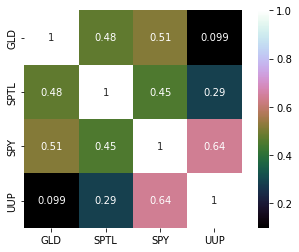

In [8]:
sns.heatmap(data.corr(), vmax=1, square=True,annot=True,cmap='cubehelix')

In [9]:
# Daily Linear Returns (%)
datareturns = data.pct_change(1)

#Remove Outliers beyong 3 standard deviation
datareturns= datareturns[datareturns.apply(lambda x :(x-x.mean()).abs()<(3*x.std()) ).all(1)]

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(datareturns)
rescaledDataset = pd.DataFrame(scaler.fit_transform(datareturns),columns = datareturns.columns, index = datareturns.index)
# summarize transformed data
datareturns.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(5)

,GLD,SPTL,SPY,UUP
Date,,,,
2012-01-04,0.596270,-0.944555,0.104069,1.314040
2012-01-05,0.809443,-0.318164,0.230217,2.645787
2012-01-06,-0.462007,0.604543,-0.374051,0.851061
2012-01-09,-0.556046,0.180468,0.203111,-0.912168
2012-01-10,1.638156,-0.317072,0.923092,-0.252885


In [11]:
# Dividing the dataset into training and testing sets
percentage = int(len(rescaledDataset) * 0.7)
X_train = rescaledDataset[:percentage]
X_test = rescaledDataset[percentage:]

X_train_raw = datareturns[:percentage]
X_test_raw = datareturns[percentage:]


stock_tickers = rescaledDataset.columns.values
n_tickers = len(stock_tickers)

In [12]:
pca = PCA()
PrincipalComponent=pca.fit(X_train)

,Explained Variance
0,43.51%
1,73.13%
2,87.74%
3,100.00%


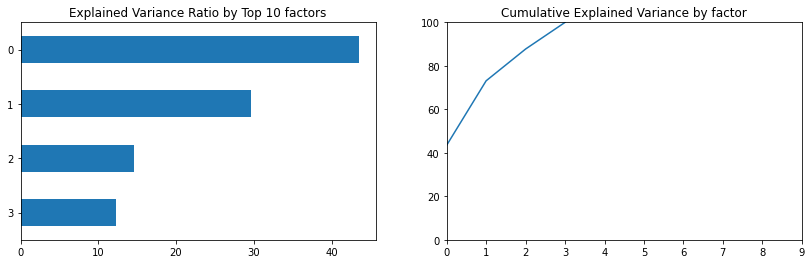

In [13]:
NumEigenvalues=10
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
Series1 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).sort_values()*100
Series2 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).cumsum()*100
Series1.plot.barh(ylim=(0,9), label="woohoo",title='Explained Variance Ratio by Top 10 factors',ax=axes[0]);
Series2.plot(ylim=(0,100),xlim=(0,9),ax=axes[1], title='Cumulative Explained Variance by factor');
# explained_variance
pd.Series(np.cumsum(pca.explained_variance_ratio_)).to_frame('Explained Variance').head(NumEigenvalues).style.format('{:,.2%}'.format)

In [14]:
def PCWeights():
    
    weights = pd.DataFrame()

    for i in range(len(pca.components_)):
        weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i])

    weights = weights.values.T
    return weights

weights=PCWeights()

In [15]:
weights[0]

array([ 2.58980096,  1.40794364, -0.55045014, -2.44729446])

In [16]:
pca.components_[0]

array([-0.66909379, -0.36375241,  0.14221277,  0.63227621])

In [17]:
weights[0]

array([ 2.58980096,  1.40794364, -0.55045014, -2.44729446])

array([[<AxesSubplot:title={'center':'Portfolio 0'}>],
       [<AxesSubplot:title={'center':'Portfolio 1'}>],
       [<AxesSubplot:title={'center':'Portfolio 2'}>],
       [<AxesSubplot:title={'center':'Portfolio 3'}>]], dtype=object)

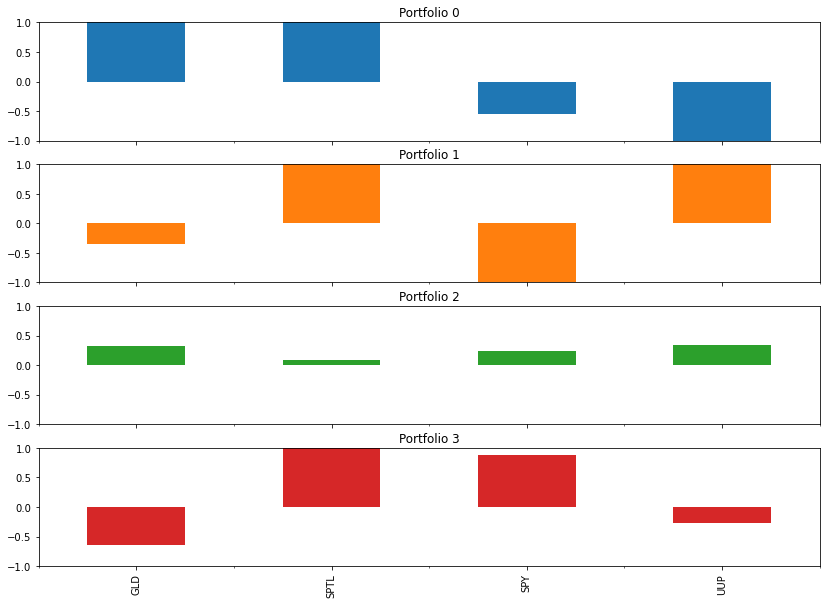

In [18]:
NumComponents=4
        
topPortfolios = pd.DataFrame(pca.components_[:NumComponents], columns=data.columns)
eigen_portfolios = topPortfolios.div(topPortfolios.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range( NumComponents)]
np.sqrt(pca.explained_variance_)
eigen_portfolios.T.plot.bar(subplots=True, layout=(int(NumComponents),1), figsize=(14,10), legend=False, sharey=True, ylim= (-1,1))

In [19]:
# Sharpe Ratio
def sharpe_ratio(ts_returns, periods_per_year=252):
    '''
    Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    It calculares the annualized return, annualized volatility, and annualized sharpe ratio.
    
    ts_returns are  returns of a signle eigen portfolio.
    '''
    n_years = ts_returns.shape[0]/periods_per_year
    annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

Eigen portfolio #2 with the highest Sharpe. Return 5.17%, vol = 4.17%, Sharpe = 1.24
     Return       Vol    Sharpe
2  0.051733  0.041722  1.239944
3  0.148349  0.188139  0.788506
1  0.221844  0.486474  0.456024
0 -0.251151  0.508740 -0.493673


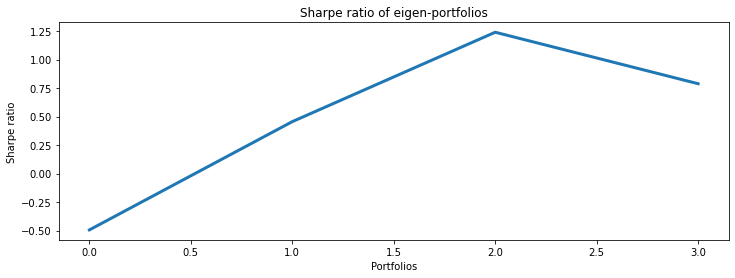

In [20]:
def optimizedPortfolio():
    n_portfolios = len(pca.components_)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0 
    stock_tickers = rescaledDataset.columns.values
    n_tickers = len(stock_tickers)
    pcs = pca.components_
    
    for i in range(n_portfolios):
        
        pc_w = pcs[i] / sum(pcs[i])
        eigen_prtfi = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)
        eigen_prti_returns = np.dot(X_train_raw.loc[:, eigen_prtfi.index], pc_w)
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_train_raw.index)
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe
        
        sharpe_metric= np.nan_to_num(sharpe_metric)
        
    # find portfolio with the highest Sharpe ratio
    highest_sharpe = np.argmax(sharpe_metric)

    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))


    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
    print(results.head(20))

    plt.show()

optimizedPortfolio()

Sum of weights of current eigen-portfolio: 100.00


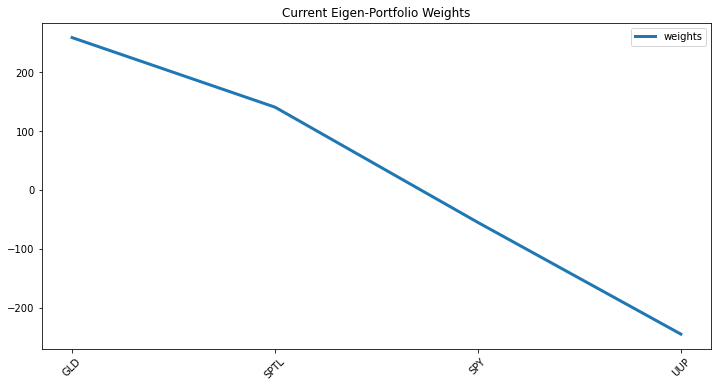

,weights
GLD,258.980096
SPTL,140.794364
SPY,-55.045014
UUP,-244.729446


In [21]:
weights = PCWeights()
portfolio = portfolio = pd.DataFrame()

def plotEigen(weights, plot=False, portfolio=portfolio):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()*100}, index = stock_tickers) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    if plot:
        print('Sum of weights of current eigen-portfolio: %.2f' % np.sum(portfolio))
        portfolio.plot(title='Current Eigen-Portfolio Weights', 
            figsize=(12,6), 
            xticks=range(0, len(stock_tickers),1), 
            rot=45, 
            linewidth=3
            )
        plt.show()


    return portfolio

# Weights are stored in arrays, where 0 is the first PC's weights.
plotEigen(weights=weights[0], plot=True)

Current Eigen-Portfolio:
Return = 33.22%
Volatility = 21.68%
Sharpe = 1.53


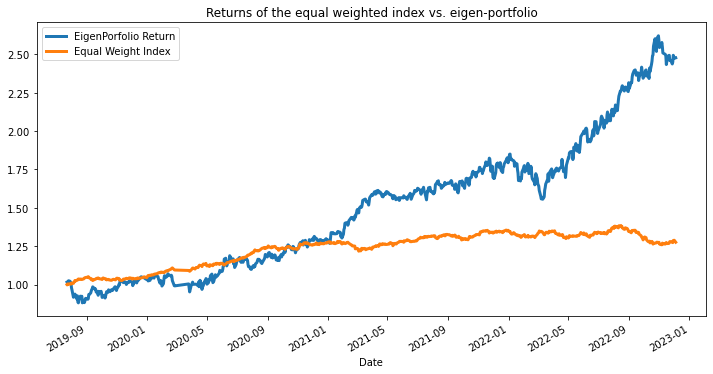

Current Eigen-Portfolio:
Return = -1.69%
Volatility = 48.24%
Sharpe = -0.03


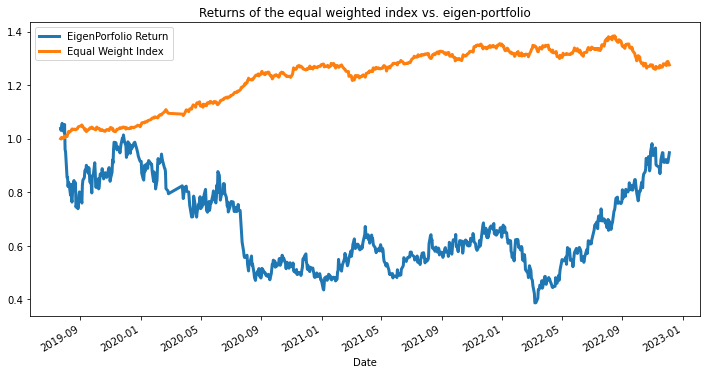

Current Eigen-Portfolio:
Return = -1.69%
Volatility = 48.24%
Sharpe = -0.03


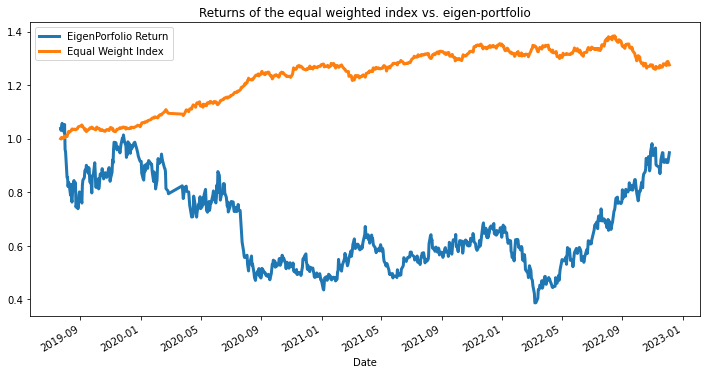

In [22]:
def Backtest(eigen):

    '''

    Plots Principle components returns against real returns.
    
    '''
   
    eigen_prtfi = pd.DataFrame(data ={'weights': eigen.squeeze()}, index = stock_tickers)
    eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)    

    eigen_prti_returns = np.dot(X_test_raw.loc[:, eigen_prtfi.index], eigen)
    eigen_portfolio_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_test_raw.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)  
    print('Current Eigen-Portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (returns*100, vol*100, sharpe))
    equal_weight_return=(X_test_raw * (1/len(pca.components_))).sum(axis=1)    
    df_plot = pd.DataFrame({'EigenPorfolio Return': eigen_portfolio_returns, 'Equal Weight Index': equal_weight_return}, index=X_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the equal weighted index vs. eigen-portfolio' , 
                          figsize=(12,6), linewidth=3)
    plt.show()
    
Backtest(eigen=weights[3])
Backtest(eigen=weights[1])
Backtest(eigen=weights[1])

In [23]:
weights[3]

array([-0.63597864,  1.03636375,  0.87268656, -0.27307167])

In [24]:
weights[1]

array([-0.35250705,  2.36017925, -2.57066267,  1.56299046])

In [25]:
#weights[1] has highest sharpe return